In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Manifold Learning

In [32]:
def make_hello(N=1000, rseed=42):
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.axis('off')
    ax.text(0.5, 0.5, 'Hello World!', va='center', ha='center', weight='bold', size=100)
    fig.savefig('hello.png')
    plt.close(fig)
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

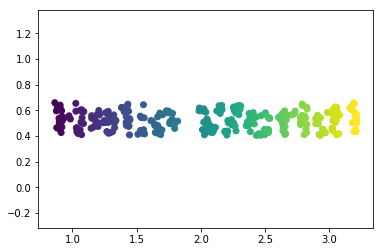

In [33]:
X = make_hello(1000)
colorize = dict(c=X[:, 0])
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

# Multidimensional Scaling (MDS)

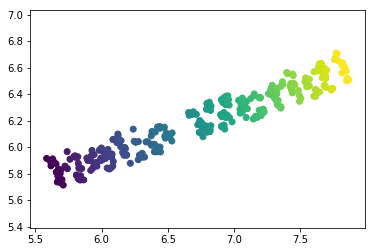

In [34]:
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)
    
X2 = rotate(X, 20) + 5
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal');

In [35]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
D.shape

(295, 295)

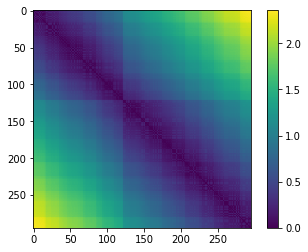

In [36]:
plt.imshow(D, zorder=2)
plt.colorbar();

In [37]:
D2 = pairwise_distances(X2)
np.allclose(D, D2)

True

CPU times: user 573 ms, sys: 45.5 ms, total: 619 ms
Wall time: 562 ms


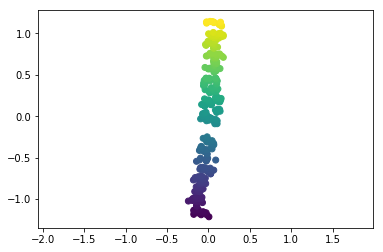

In [38]:
%%time
from sklearn.manifold import MDS
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal');

In [39]:
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])
    
X3 = random_projection(X, 3)
X3.shape

(295, 3)

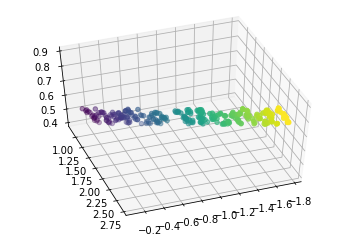

In [40]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2],
             **colorize)
ax.view_init(azim=70, elev=50)

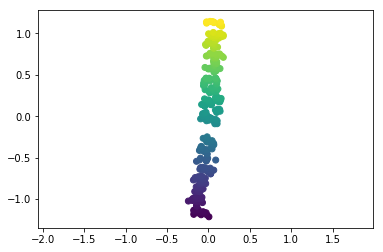

In [41]:
model = MDS(n_components=2, random_state=1)
out3 = model.fit_transform(X3)
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal');

### Nonlinear Embeddings

In [42]:
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_hello_s_curve(X)

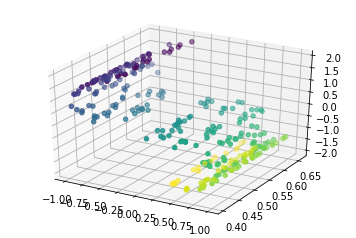

In [43]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2], **colorize);

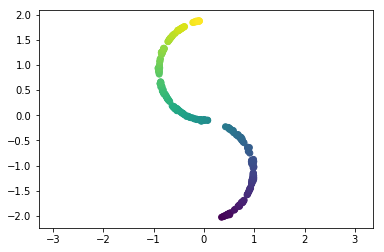

In [44]:
model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal');

# Locally Linear Embedding (LLE)

/Users/DannyShau/anaconda/envs/py3.5/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


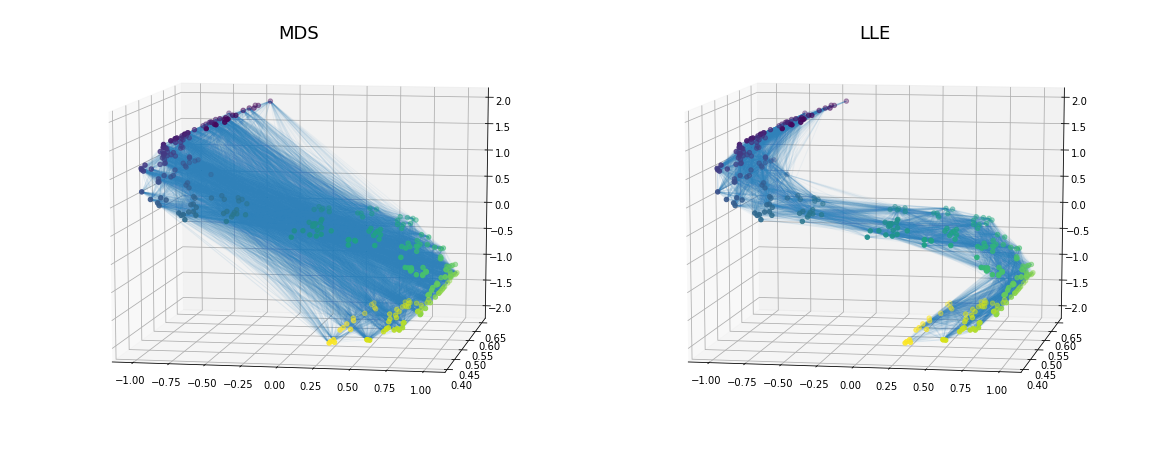

In [49]:
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from sklearn.neighbors import NearestNeighbors
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
lines_MDS = [(XS[i], XS[j]) for i in ind[:100] for j in ind[100:200]]

nbrs = NearestNeighbors(n_neighbors=100).fit(XS).kneighbors(XS[ind[:100]])[1]
lines_LLE = [(XS[ind[i]], XS[j]) for i in range(100) for j in nbrs[i]]
titles = ['MDS', 'LLE']
fig, ax = plt.subplots(1, 2, figsize=(16, 6), subplot_kw=dict(projection='3d', axisbg='none'))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0)
for axi, title, lines in zip(ax, titles, [lines_MDS, lines_LLE]):
    axi.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2], **colorize);
    axi.add_collection(Line3DCollection(lines, lw=1, alpha=0.05))
    axi.view_init(elev=10, azim=-80)
    axi.set_title(title, size=18)

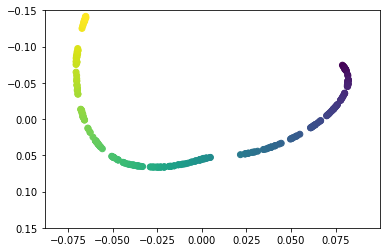

In [50]:
from sklearn.manifold import LocallyLinearEmbedding
model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified', eigen_solver='dense')
out = model.fit_transform(XS)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15);

# Example: Faces

In [52]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=100)
print(faces.data.shape)

(1140, 2914)


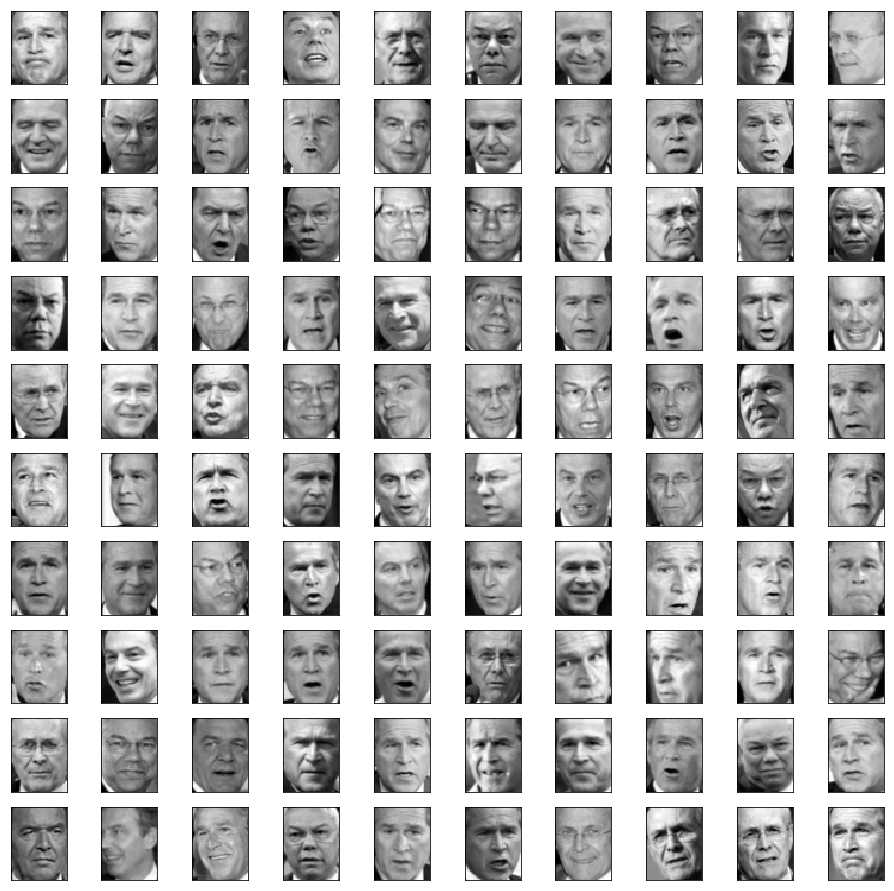

In [54]:
fig, ax = plt.subplots(10, 10, figsize=(16, 16), subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

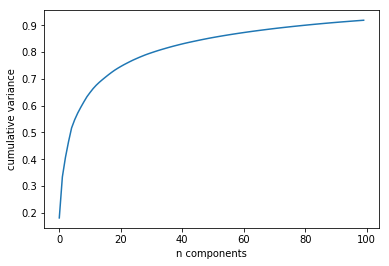

In [56]:
from sklearn.decomposition import PCA
model = PCA(n_components=100, svd_solver='randomized')
model.fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance');

In [57]:
from sklearn.manifold import Isomap
model = Isomap(n_components=2)
proj = model.fit_transform(faces.data)
print(proj.shape)

(1140, 2)


In [58]:
from matplotlib import offsetbox
def plot_components(data, model, images=None, ax=None, thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(images[i], cmap=cmap), proj[i])
            ax.add_artist(imagebox)

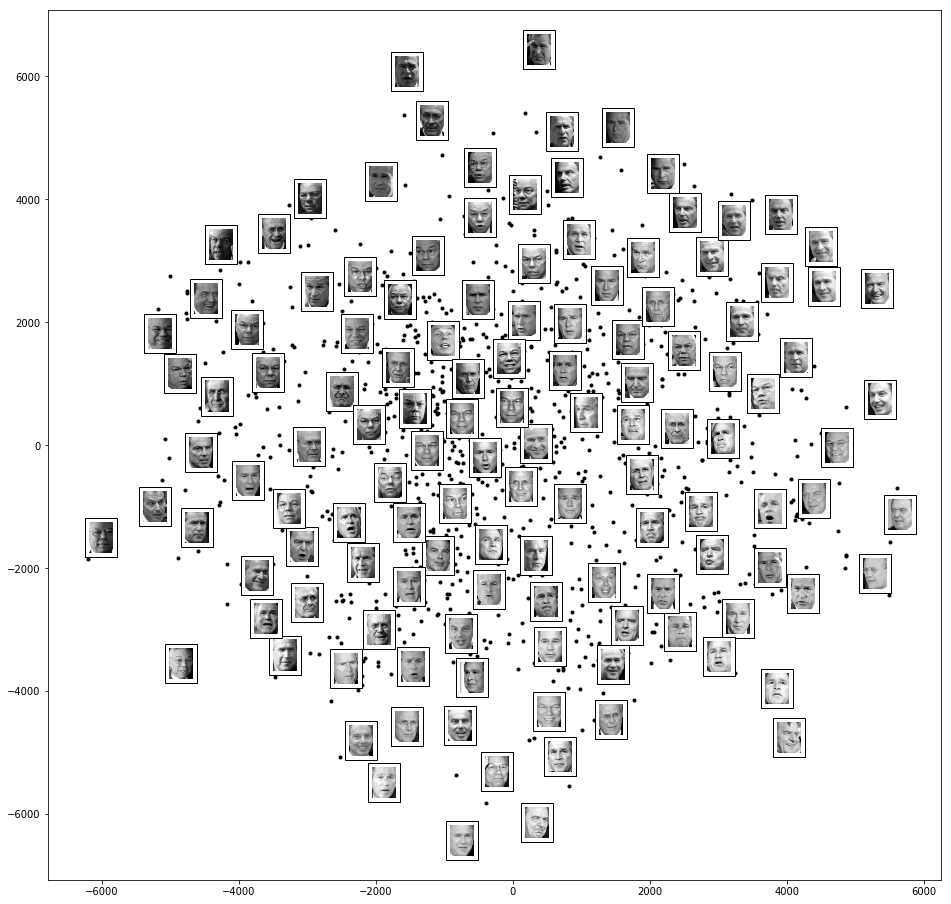

In [59]:
fig, ax = plt.subplots(figsize=(16, 16))
plot_components(faces.data, model=Isomap(n_components=2), images=faces.images[:, ::2, ::2])

# Example: Digits

In [ ]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
print(mnist.data.shape)

In [ ]:
fig, ax = plt.subplots(10, 10, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(mnist.data[1250 * i].reshape(28, 28), cmap='gray_r')